In [2]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999

<IPython.core.display.Javascript object>

# Exploratory Data Analysis

## Objectif: comprendre au maximum les données dont on dispose pour définir une stratégie de modélisation.

### I - Analyse de la forme:
	§ Identification de la target
	§ Nombre des lignes et de colonnes 
	§ Identification des valeurs manquantes 
	§ Types de variables

### II - Analyse du fond:
	§ Visualisation de la target (histogramme/boxplot)
	§ Compréhension des différentes variables (recherche)
	§ Visualisation des relations : features/target
	§ Identification des outliers


## Pre-processing

### Objectif: transformer le data pour le mettre dans un format propice au machine learning

	§ Création du Train Set / Test Set
	§ Élimination des NaN : dropna(), imputation, colonne"vides"
	§ Encodage
	§ Suppression des outliers néfastes au modèle
	§ Feature selection
	§ Feature engineering
	§ Feature scaling

## Modelling

### Objectif: développer un modèle de machine learning capable de répondre a l'objectif final.

	§ Définir une fonction d'évaluation
	§ Entrainement de différents modèles
	§ Optimisation avec GridSearchCV
	§ Analyse des erreurs et retour au Preprocessing / EDALearning Curve et prise de décision

# 1. Exploratory Data Analysis

## Objectif :
- Comprendre du mieux possible nos données (un petit pas en avant vaut mieux qu'un grand pas en arriere)
- Développer une premiere stratégie de modélisation 

## Checklist de base
#### Analyse de Forme :
- **variable target** : SARS-Cov-2 exam result
- **lignes et colonnes** : 5644, 111
- **types de variables** : qualitatives : 70, quantitatives : 41
- **Analyse des valeurs manquantes** :
    - beaucoup de NaN (moitié des variables > 90% de NaN)
    - 2 groupes de données 76% -> Test viral, 89% -> taux sanguins

#### Analyse de Fond :
- **Visualisation de la target** :
    - 10% de positifs (558 / 5000)
    
    
    
- **Signification des variables** :
    -  variables continues standardisées, skewed (asymétriques), test sanguin
    - age quantile : difficile d'interpreter ce graphique, clairement ces données ont été traitées, on pourrait penser 0-5, mais cela pourrait aussi etre une transformation mathématique. On peut pas savoir car la personne qui a mit ce dataset ne le précise nul part. Mais ca n'est pas tres important
    - variable qualitative : binaire (0, 1), viral, Rhinovirus qui semble tres élevée



- **Relation Variables / Target** :
    - target / blood : les taux de Monocytes, Platelets, Leukocytes semblent liés au covid-19 -> hypothese a tester
    - target/age : les individus de faible age sont tres peu contaminés ? -> attention on ne connait pas l'age, et on ne sait pas de quand date le dataset (s'il s'agit des enfants on sait que les enfants sont touchés autant que les adultes). En revanche cette variable pourra etre intéressante pour la comparer avec les résultats de tests sanguins
    - target / viral : les doubles maladies sont tres rares. Rhinovirus/Enterovirus positif - covid-19 négatif ? -> hypothese a tester ? mais il est possible que la région est subie une épidémie de ce virus. De plus on peut tres bien avoir 2 virus en meme temps. Tout ca n'a aucun lien avec le covid-19
    
    
    
## Analyse plus détaillée

- **Relation Variables / Variables** :
    - blood_data / blood_data : certaines variables sont tres corrélées : +0.9 (a suveiller plus tard)
    - blood_data / age : tres faible corrélation entre age et taux sanguins
    - viral / viral : influenza rapid test donne de mauvais résultats, il fauda peut-etre la laisser tomber
    - relation maladie / blood data : Les taux sanguins entre malades et covid-19 sont différents
    - relation hospitalisation / est malade : 
    - relation hospitalisation / blood : intéressant dans le cas ou on voudrait prédire dans quelle service un patient devrait aller


- **NaN analyse** : viral : 1350(92/8), blood : 600(87/13), both : 90

### hypotheses nulle (H0): 

- Les individus atteints du covid-19 ont des taux de Leukocytes, Monocytes, Platelets significativement différents
    - H0 = Les taux moyens sont ÉGAUX chez les individus positifs et négatifs

- Les individus atteints d'une quelconque maladie ont des taux significativement différents


    

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
pd.set_option('display.max_row', 111)
pd.set_option('display.max_column', 111)

In [5]:
url = 'https://raw.githubusercontent.com/MachineLearnia/Python-Machine-Learning/master/Dataset/dataset.csv'
data = pd.read_csv(url, index_col=0, encoding = "ISO-8859-1")

In [6]:
data.head()

Patient age quantile SARS-Cov-2 exam result  \
Patient ID                                                     
44477f75e8169d2                    13               negative   
126e9dd13932f68                    17               negative   
a46b4402a0e5696                     8               negative   
f7d619a94f97c45                     5               negative   
d9e41465789c2b5                    15               negative   

                 Patient addmited to regular ward (1=yes, 0=no)  \
Patient ID                                                        
44477f75e8169d2                                               0   
126e9dd13932f68                                               0   
a46b4402a0e5696                                               0   
f7d619a94f97c45                                               0   
d9e41465789c2b5                                               0   

                 Patient addmited to semi-intensive unit (1=yes, 0=no)  \
Patient ID                                                               
44477f75e8169d2                                                  0       
126e9dd13932f68                                                  0       
a46b4402a0e5696                                                  0       
f7d619a94f97c45                                                  0       
d9e41465789c2b5                                                  0       

                 Patient addmited to intensive care unit (1=yes, 0=no)  \
Patient ID                                                               
44477f75e8169d2                                                  0       
126e9dd13932f68                                                  0       
a46b4402a0e5696                                                  0       
f7d619a94f97c45                                                  0       
d9e41465789c2b5                                                  0       

                 Hematocrit  Hemoglobin  Platelets  Mean platelet volume   \
Patient ID                                                                  
44477f75e8169d2         NaN         NaN        NaN                    NaN   
126e9dd13932f68    0.236515    -0.02234  -0.517413               0.010677   
a46b4402a0e5696         NaN         NaN        NaN                    NaN   
f7d619a94f97c45         NaN         NaN        NaN                    NaN   
d9e41465789c2b5         NaN         NaN        NaN                    NaN   

                 Red blood Cells  Lymphocytes  \
Patient ID                                      
44477f75e8169d2              NaN          NaN   
126e9dd13932f68         0.102004     0.318366   
a46b4402a0e5696              NaN          NaN   
f7d619a94f97c45              NaN          NaN   
d9e41465789c2b5              NaN          NaN   

                 Mean corpuscular hemoglobin concentration (MCHC)  Leukocytes  \
Patient ID                                                                      
44477f75e8169d2                                               NaN         NaN   
126e9dd13932f68                                          -0.95079    -0.09461   
a46b4402a0e5696                                               NaN         NaN   
f7d619a94f97c45                                               NaN         NaN   
d9e41465789c2b5                                               NaN         NaN   

                 Basophils  Mean corpuscular hemoglobin (MCH)  Eosinophils  \
Patient ID                                                                   
44477f75e8169d2        NaN                                NaN          NaN   
126e9dd13932f68  -0.223767                          -0.292269     1.482158   
a46b4402a0e5696        NaN                                NaN          NaN   
f7d619a94f97c45        NaN                                NaN          NaN   
d9e41465789c2b5        NaN                                NaN          NaN   

                 Mean corpuscular volume (MCV)  Monocytes  \


### Analyse de la forme des données

In [7]:
df = data.copy()

In [8]:
df.shape

(5644, 110)

<AxesSubplot:ylabel='None'>

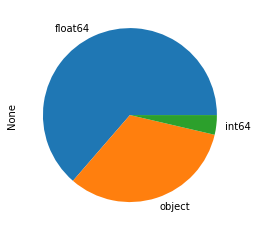

In [9]:
df.dtypes.value_counts().plot.pie()

<AxesSubplot:ylabel='Patient ID'>

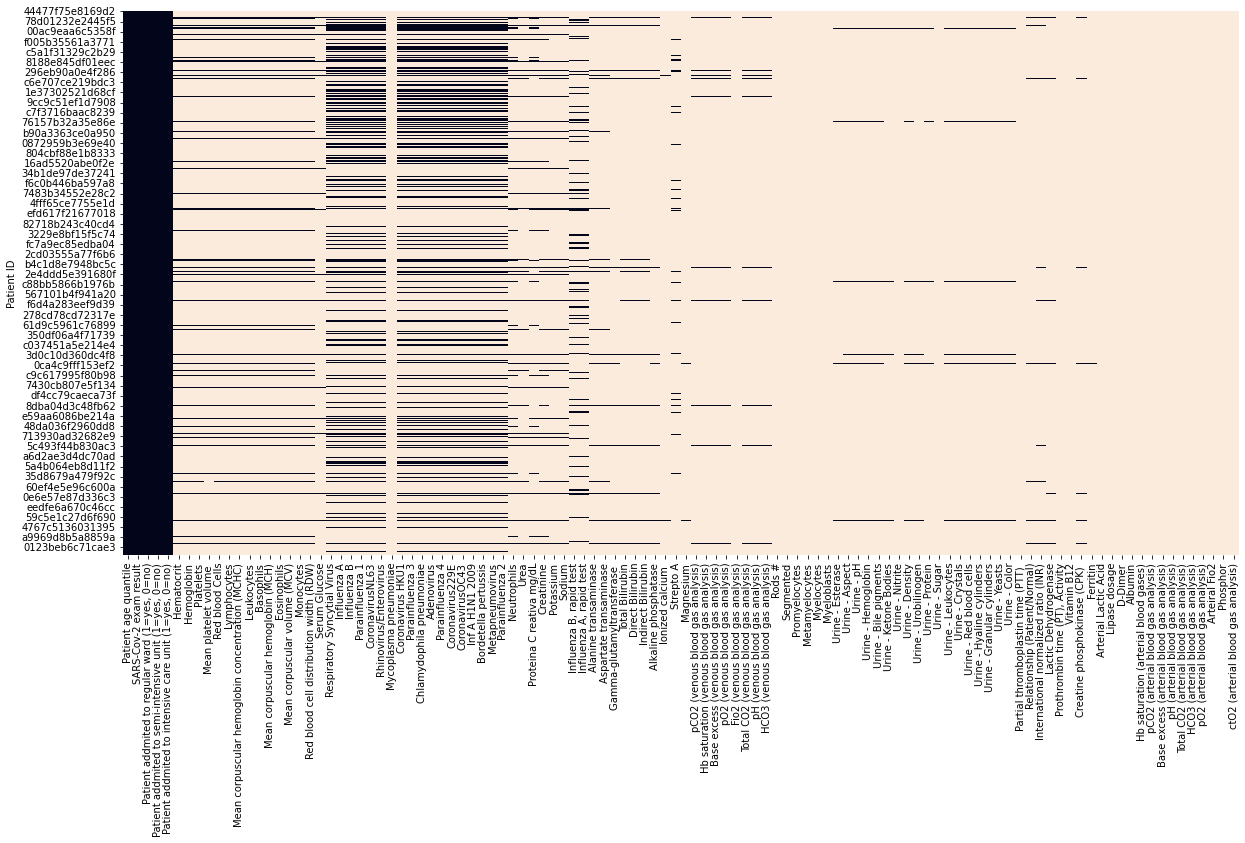

In [10]:
plt.figure(figsize=(20,10))
sns.heatmap(df.isna(), cbar=False)

In [11]:
(df.isna().sum()/df.shape[0]).sort_values(ascending=True)

Patient age quantile                                     0.000000
SARS-Cov-2 exam result                                   0.000000
Patient addmited to regular ward (1=yes, 0=no)           0.000000
Patient addmited to semi-intensive unit (1=yes, 0=no)    0.000000
Patient addmited to intensive care unit (1=yes, 0=no)    0.000000
Influenza B                                              0.760099
Respiratory Syncytial Virus                              0.760099
Influenza A                                              0.760099
Rhinovirus/Enterovirus                                   0.760454
Inf A H1N1 2009                                          0.760454
CoronavirusOC43                                          0.760454
Coronavirus229E                                          0.760454
Parainfluenza 4                                          0.760454
Adenovirus                                               0.760454
Chlamydophila pneumoniae                                 0.760454
Parainflue

## Analyse du Fond
### 1. Visulation initiale - Elimination des colonnes inutiles

In [12]:
df = df[df.columns[df.isna().sum()/df.shape[0] <0.9]]
df.head()

Patient age quantile SARS-Cov-2 exam result  \
Patient ID                                                     
44477f75e8169d2                    13               negative   
126e9dd13932f68                    17               negative   
a46b4402a0e5696                     8               negative   
f7d619a94f97c45                     5               negative   
d9e41465789c2b5                    15               negative   

                 Patient addmited to regular ward (1=yes, 0=no)  \
Patient ID                                                        
44477f75e8169d2                                               0   
126e9dd13932f68                                               0   
a46b4402a0e5696                                               0   
f7d619a94f97c45                                               0   
d9e41465789c2b5                                               0   

                 Patient addmited to semi-intensive unit (1=yes, 0=no)  \
Patient ID                                                               
44477f75e8169d2                                                  0       
126e9dd13932f68                                                  0       
a46b4402a0e5696                                                  0       
f7d619a94f97c45                                                  0       
d9e41465789c2b5                                                  0       

                 Patient addmited to intensive care unit (1=yes, 0=no)  \
Patient ID                                                               
44477f75e8169d2                                                  0       
126e9dd13932f68                                                  0       
a46b4402a0e5696                                                  0       
f7d619a94f97c45                                                  0       
d9e41465789c2b5                                                  0       

                 Hematocrit  Hemoglobin  Platelets  Mean platelet volume   \
Patient ID                                                                  
44477f75e8169d2         NaN         NaN        NaN                    NaN   
126e9dd13932f68    0.236515    -0.02234  -0.517413               0.010677   
a46b4402a0e5696         NaN         NaN        NaN                    NaN   
f7d619a94f97c45         NaN         NaN        NaN                    NaN   
d9e41465789c2b5         NaN         NaN        NaN                    NaN   

                 Red blood Cells  Lymphocytes  \
Patient ID                                      
44477f75e8169d2              NaN          NaN   
126e9dd13932f68         0.102004     0.318366   
a46b4402a0e5696              NaN          NaN   
f7d619a94f97c45              NaN          NaN   
d9e41465789c2b5              NaN          NaN   

                 Mean corpuscular hemoglobin concentration (MCHC)  Leukocytes  \
Patient ID                                                                      
44477f75e8169d2                                               NaN         NaN   
126e9dd13932f68                                          -0.95079    -0.09461   
a46b4402a0e5696                                               NaN         NaN   
f7d619a94f97c45                                               NaN         NaN   
d9e41465789c2b5                                               NaN         NaN   

                 Basophils  Mean corpuscular hemoglobin (MCH)  Eosinophils  \
Patient ID                                                                   
44477f75e8169d2        NaN                                NaN          NaN   
126e9dd13932f68  -0.223767                          -0.292269     1.482158   
a46b4402a0e5696        NaN                                NaN          NaN   
f7d619a94f97c45        NaN                                NaN          NaN   
d9e41465789c2b5        NaN                                NaN          NaN   

                 Mean corpuscular volume (MCV)  Monocytes  \


<AxesSubplot:ylabel='Patient ID'>

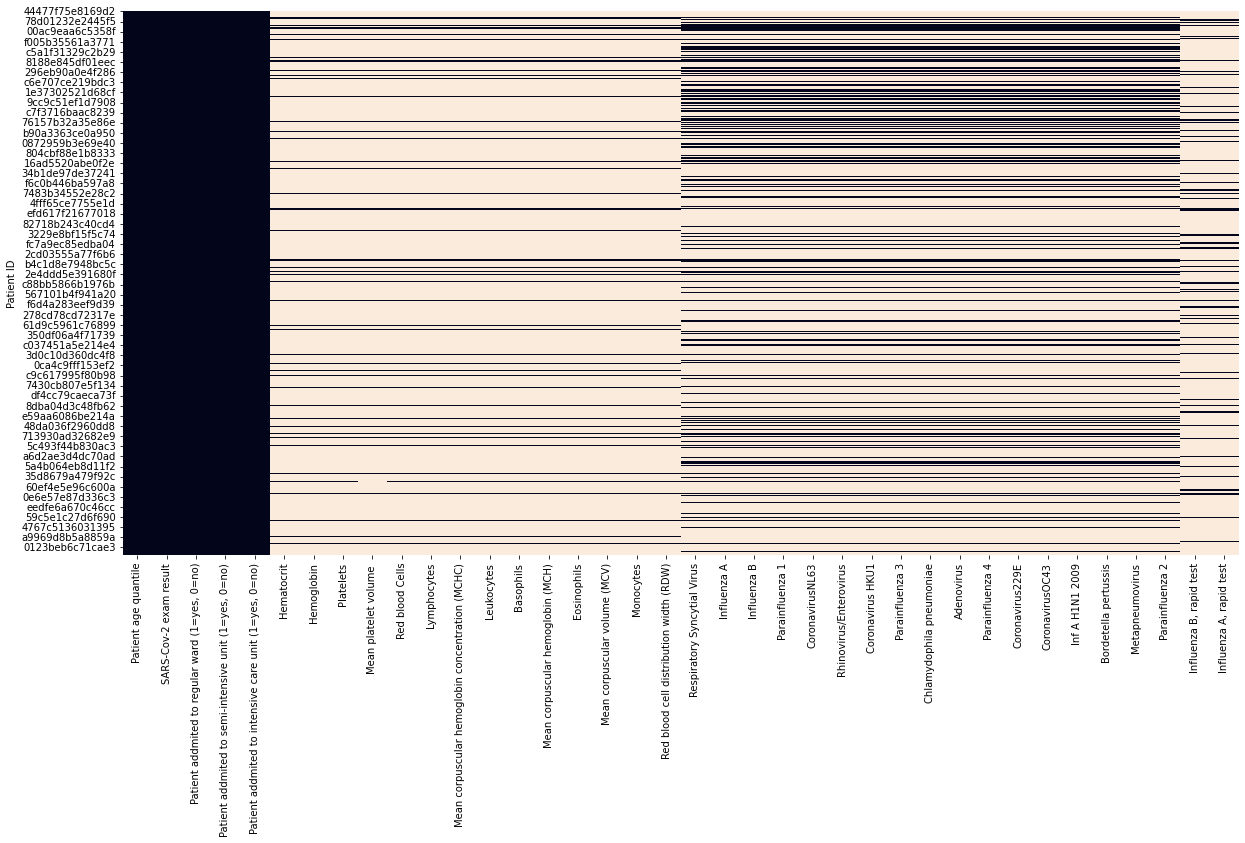

In [13]:
plt.figure(figsize=(20,10))
sns.heatmap(df.isna(), cbar=False)

In [14]:
# df = df.drop('Patient ID', axis=1)

In [15]:
df.head()

Patient age quantile SARS-Cov-2 exam result  \
Patient ID                                                     
44477f75e8169d2                    13               negative   
126e9dd13932f68                    17               negative   
a46b4402a0e5696                     8               negative   
f7d619a94f97c45                     5               negative   
d9e41465789c2b5                    15               negative   

                 Patient addmited to regular ward (1=yes, 0=no)  \
Patient ID                                                        
44477f75e8169d2                                               0   
126e9dd13932f68                                               0   
a46b4402a0e5696                                               0   
f7d619a94f97c45                                               0   
d9e41465789c2b5                                               0   

                 Patient addmited to semi-intensive unit (1=yes, 0=no)  \
Patient ID                                                               
44477f75e8169d2                                                  0       
126e9dd13932f68                                                  0       
a46b4402a0e5696                                                  0       
f7d619a94f97c45                                                  0       
d9e41465789c2b5                                                  0       

                 Patient addmited to intensive care unit (1=yes, 0=no)  \
Patient ID                                                               
44477f75e8169d2                                                  0       
126e9dd13932f68                                                  0       
a46b4402a0e5696                                                  0       
f7d619a94f97c45                                                  0       
d9e41465789c2b5                                                  0       

                 Hematocrit  Hemoglobin  Platelets  Mean platelet volume   \
Patient ID                                                                  
44477f75e8169d2         NaN         NaN        NaN                    NaN   
126e9dd13932f68    0.236515    -0.02234  -0.517413               0.010677   
a46b4402a0e5696         NaN         NaN        NaN                    NaN   
f7d619a94f97c45         NaN         NaN        NaN                    NaN   
d9e41465789c2b5         NaN         NaN        NaN                    NaN   

                 Red blood Cells  Lymphocytes  \
Patient ID                                      
44477f75e8169d2              NaN          NaN   
126e9dd13932f68         0.102004     0.318366   
a46b4402a0e5696              NaN          NaN   
f7d619a94f97c45              NaN          NaN   
d9e41465789c2b5              NaN          NaN   

                 Mean corpuscular hemoglobin concentration (MCHC)  Leukocytes  \
Patient ID                                                                      
44477f75e8169d2                                               NaN         NaN   
126e9dd13932f68                                          -0.95079    -0.09461   
a46b4402a0e5696                                               NaN         NaN   
f7d619a94f97c45                                               NaN         NaN   
d9e41465789c2b5                                               NaN         NaN   

                 Basophils  Mean corpuscular hemoglobin (MCH)  Eosinophils  \
Patient ID                                                                   
44477f75e8169d2        NaN                                NaN          NaN   
126e9dd13932f68  -0.223767                          -0.292269     1.482158   
a46b4402a0e5696        NaN                                NaN          NaN   
f7d619a94f97c45        NaN                                NaN          NaN   
d9e41465789c2b5        NaN                                NaN          NaN   

                 Mean corpuscular volume (MCV)  Monocytes  \


### Examen de la colonne target

In [16]:
df['SARS-Cov-2 exam result'].value_counts(normalize=True)

negative    0.901134
positive    0.098866
Name: SARS-Cov-2 exam result, dtype: float64

### histogrames des variables continues 

/usr/local/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

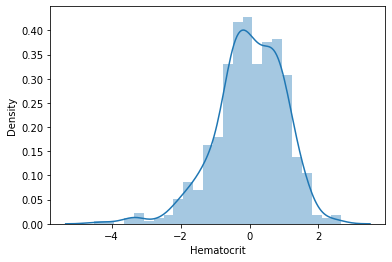

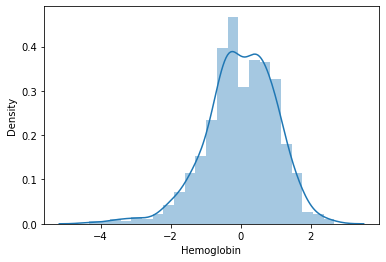

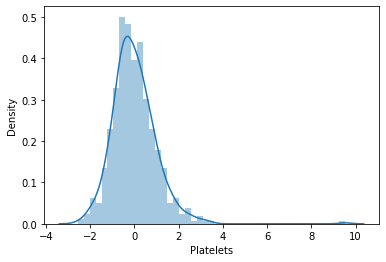

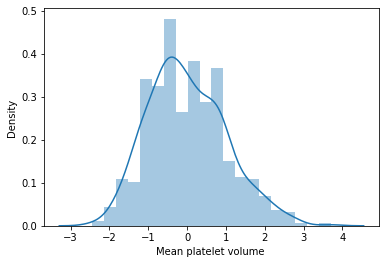

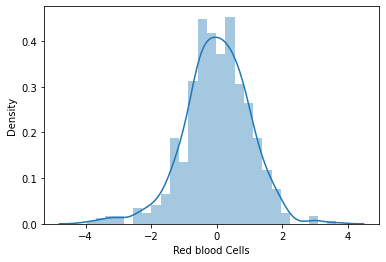

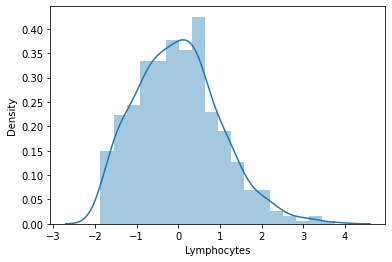

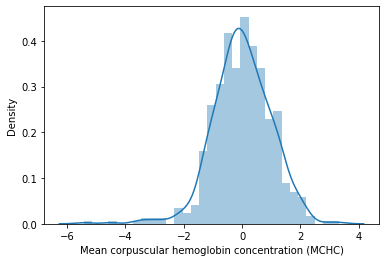

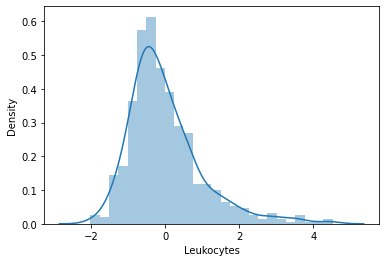

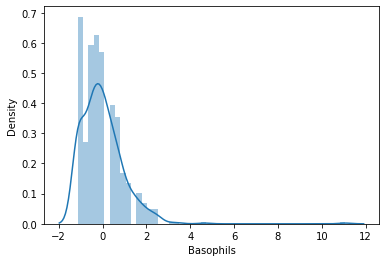

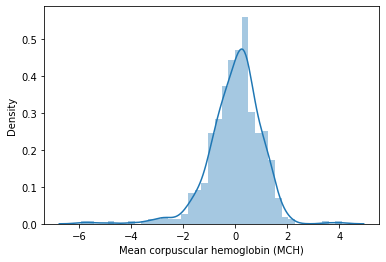

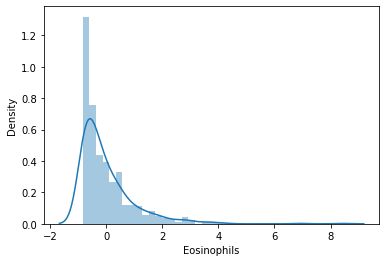

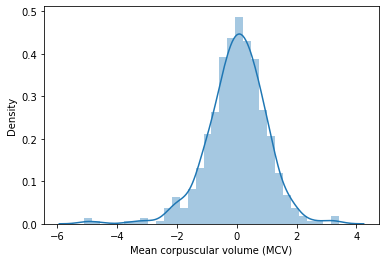

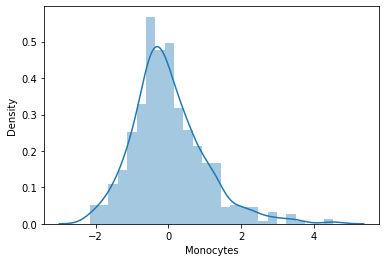

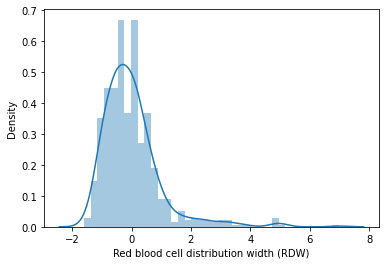

In [17]:
for col in df.select_dtypes('float'):
    plt.figure()
    sns.distplot(df[col])

/usr/local/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Patient age quantile', ylabel='Density'>

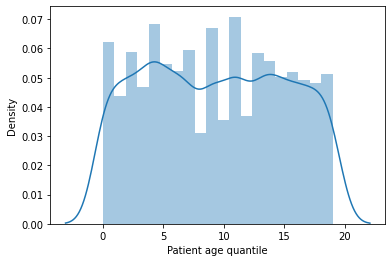

In [18]:
sns.distplot(df['Patient age quantile'], bins=20)

In [19]:
df['Patient age quantile'].value_counts()

11    380
4     366
9     359
0     334
7     319
2     315
13    313
14    299
5     294
6     281
16    279
19    275
15    269
17    263
18    259
3     251
1     234
12    197
10    190
8     167
Name: Patient age quantile, dtype: int64

### Variables Qualitatives

In [20]:
for col in df.select_dtypes('object'):
    print(f'{col :-<40} {df[col].unique()}')

SARS-Cov-2 exam result------------------ ['negative' 'positive']
Respiratory Syncytial Virus------------- [nan 'not_detected' 'detected']
Influenza A----------------------------- [nan 'not_detected' 'detected']
Influenza B----------------------------- [nan 'not_detected' 'detected']
Parainfluenza 1------------------------- [nan 'not_detected' 'detected']
CoronavirusNL63------------------------- [nan 'not_detected' 'detected']
Rhinovirus/Enterovirus------------------ [nan 'detected' 'not_detected']
Coronavirus HKU1------------------------ [nan 'not_detected' 'detected']
Parainfluenza 3------------------------- [nan 'not_detected' 'detected']
Chlamydophila pneumoniae---------------- [nan 'not_detected' 'detected']
Adenovirus------------------------------ [nan 'not_detected' 'detected']
Parainfluenza 4------------------------- [nan 'not_detected' 'detected']
Coronavirus229E------------------------- [nan 'not_detected' 'detected']
CoronavirusOC43------------------------- [nan 'not_detected

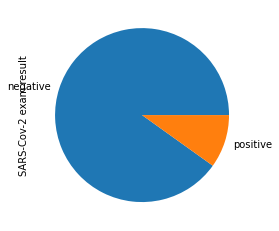

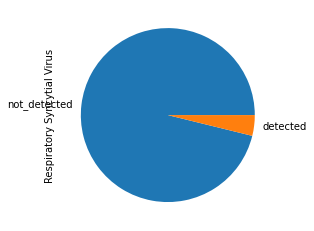

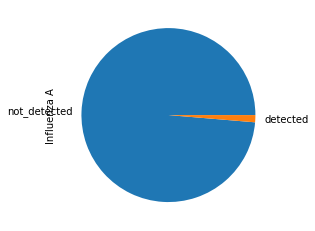

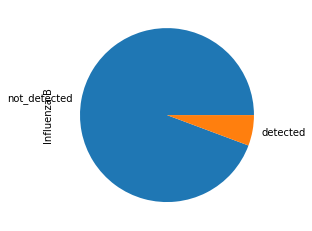

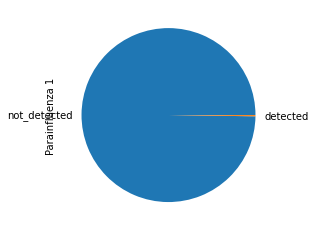

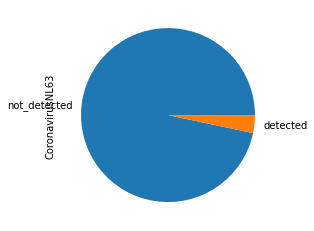

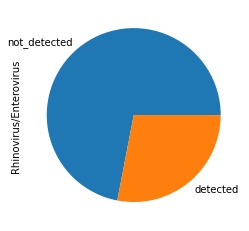

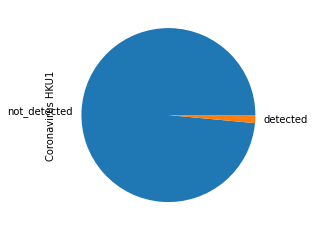

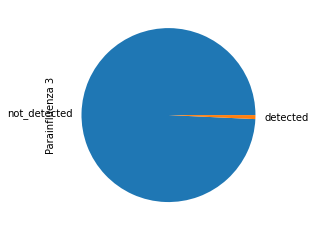

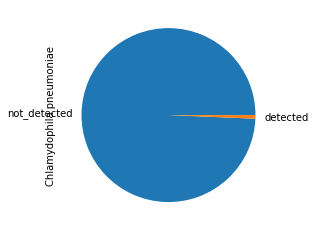

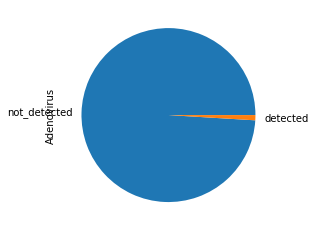

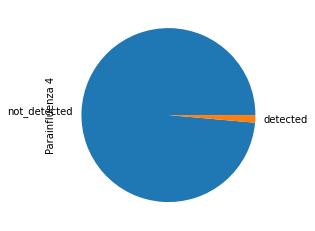

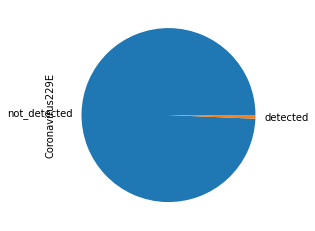

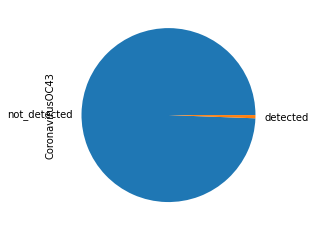

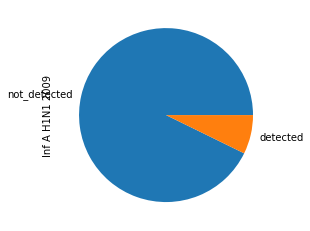

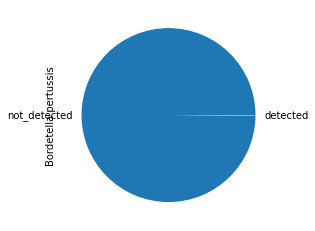

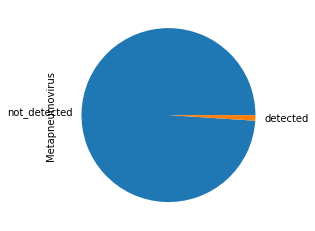

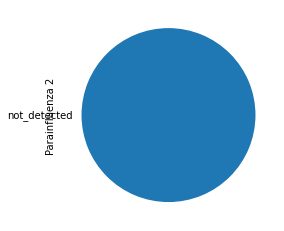

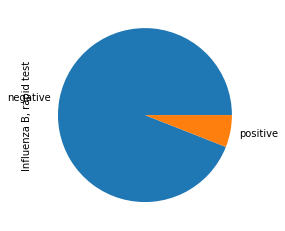

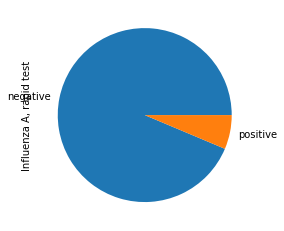

In [21]:
for col in df.select_dtypes('object'):
    plt.figure()
    df[col].value_counts().plot.pie()

## Relation Target / Variables
### Création de sous-ensembles positifs et négatifs

In [22]:
positive_df = df[df['SARS-Cov-2 exam result'] == 'positive']
positive_df

Patient age quantile SARS-Cov-2 exam result  \
Patient ID                                                     
78511c183ae18bc                     7               positive   
d7834ed75f2da44                    16               positive   
b16b49f7bd3e692                    10               positive   
4382f5ea05e60c4                     2               positive   
d3729cd2658ca64                    15               positive   
...                               ...                    ...   
5c386388ba3c3f0                    16               positive   
9f8dfe2ae239238                     4               positive   
db77903261ab6d0                    15               positive   
ae66feb9e4dc3a0                     3               positive   
2697fdccbfeb7f7                    19               positive   

                 Patient addmited to regular ward (1=yes, 0=no)  \
Patient ID                                                        
78511c183ae18bc                                               0   
d7834ed75f2da44                                               1   
b16b49f7bd3e692                                               0   
4382f5ea05e60c4                                               0   
d3729cd2658ca64                                               0   
...                                                         ...   
5c386388ba3c3f0                                               0   
9f8dfe2ae239238                                               0   
db77903261ab6d0                                               0   
ae66feb9e4dc3a0                                               0   
2697fdccbfeb7f7                                               0   

                 Patient addmited to semi-intensive unit (1=yes, 0=no)  \
Patient ID                                                               
78511c183ae18bc                                                  0       
d7834ed75f2da44                                                  0       
b16b49f7bd3e692                                                  0       
4382f5ea05e60c4                                                  0       
d3729cd2658ca64                                                  0       
...                                                            ...       
5c386388ba3c3f0                                                  0       
9f8dfe2ae239238                                                  0       
db77903261ab6d0                                                  0       
ae66feb9e4dc3a0                                                  0       
2697fdccbfeb7f7                                                  0       

                 Patient addmited to intensive care unit (1=yes, 0=no)  \
Patient ID                                                               
78511c183ae18bc                                                  0       
d7834ed75f2da44                                                  0       
b16b49f7bd3e692                                                  0       
4382f5ea05e60c4                                                  0       
d3729cd2658ca64                                                  0       
...                                                            ...       
5c386388ba3c3f0                                                  0       
9f8dfe2ae239238                                                  0       
db77903261ab6d0                                                  0       
ae66feb9e4dc3a0                                                  0       
2697fdccbfeb7f7                                                  0       

                 Hematocrit  Hemoglobin  Platelets  Mean platelet volume   \
Patient ID                                                                  
78511c183ae18bc         NaN         NaN        NaN                    NaN   
d7834ed75f2da44         NaN         NaN        NaN                    NaN   
b16b49f7bd3e692         NaN         NaN        NaN                    NaN   
4

In [23]:
negative_df = df[df['SARS-Cov-2 exam result'] == 'negative']

### Création des ensembles Blood et viral

In [24]:
missing_rate = df.isna().sum()/df.shape[0]

In [25]:
blood_columns = df.columns[(missing_rate < 0.9) & (missing_rate >0.88)]
blood_columns

Index(['Hematocrit', 'Hemoglobin', 'Platelets', 'Mean platelet volume ',
       'Red blood Cells', 'Lymphocytes',
       'Mean corpuscular hemoglobin concentration (MCHC)', 'Leukocytes',
       'Basophils', 'Mean corpuscular hemoglobin (MCH)', 'Eosinophils',
       'Mean corpuscular volume (MCV)', 'Monocytes',
       'Red blood cell distribution width (RDW)'],
      dtype='object')

In [26]:
viral_columns = df.columns[(missing_rate < 0.88) & (missing_rate > 0.75)]

## Target / Blood

/usr/local/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

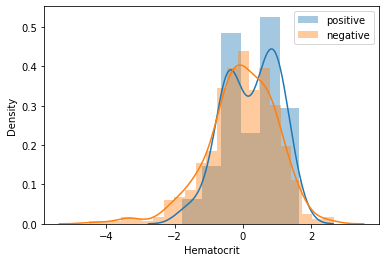

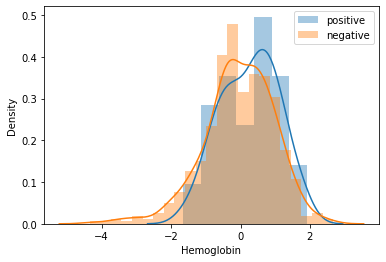

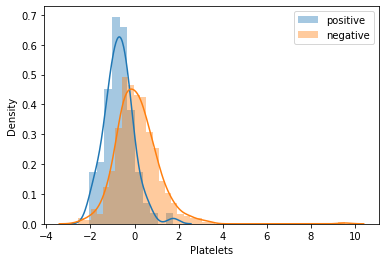

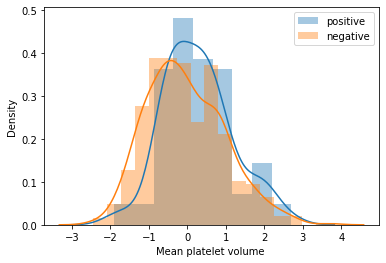

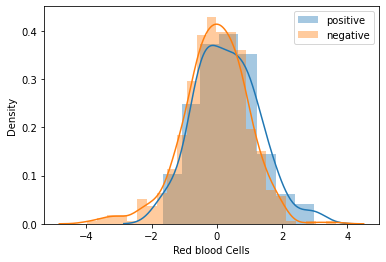

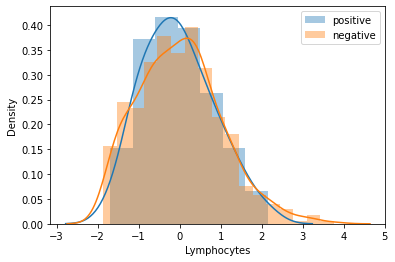

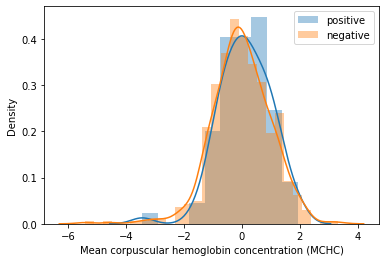

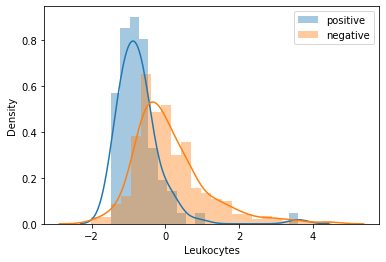

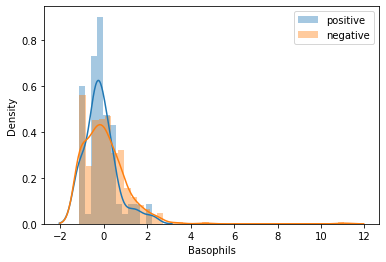

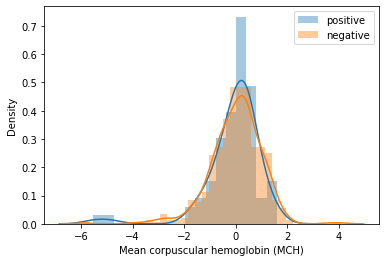

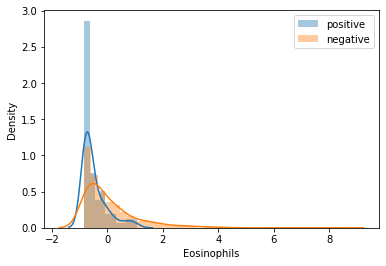

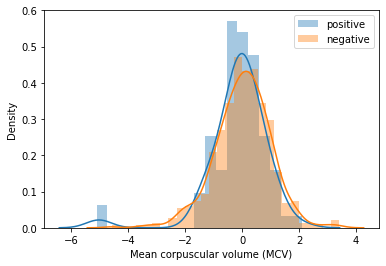

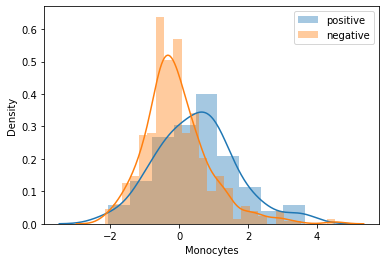

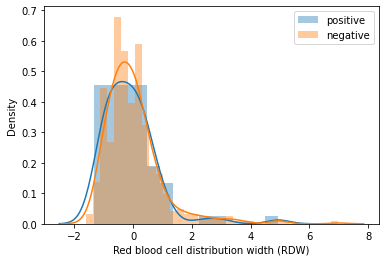

In [27]:
for col in blood_columns:
    plt.figure()
    sns.distplot(positive_df[col], label='positive')
    sns.distplot(negative_df[col], label='negative')
    plt.legend()

### Relation Target / age

<AxesSubplot:xlabel='Patient age quantile', ylabel='count'>

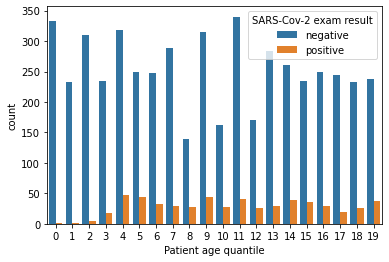

In [28]:
sns.countplot(x='Patient age quantile', hue='SARS-Cov-2 exam result', data=df)

### Relation Target / Viral

In [29]:
pd.crosstab(df['SARS-Cov-2 exam result'], df['Influenza A'])

Influenza A             detected  not_detected
SARS-Cov-2 exam result                        
negative                      18          1224
positive                       0           112

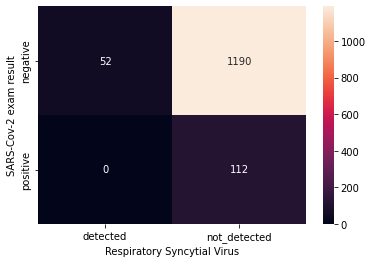

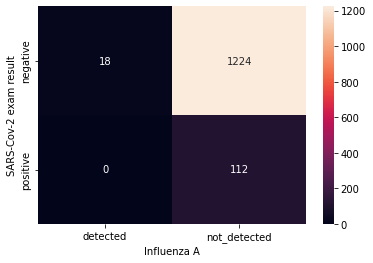

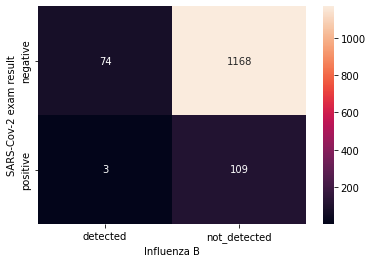

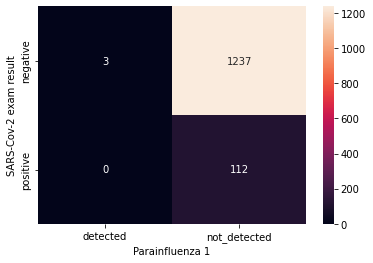

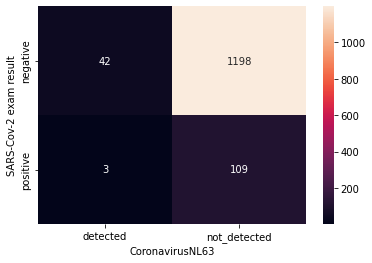

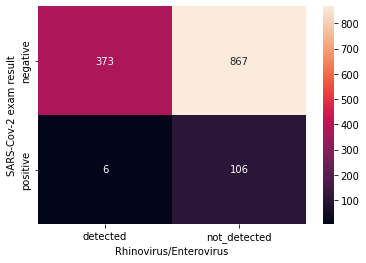

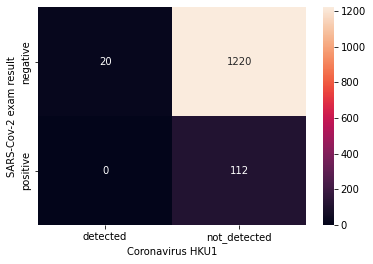

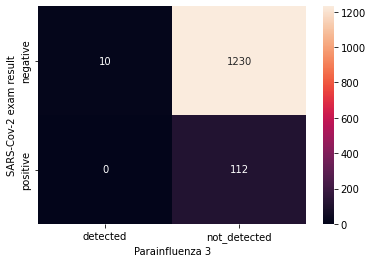

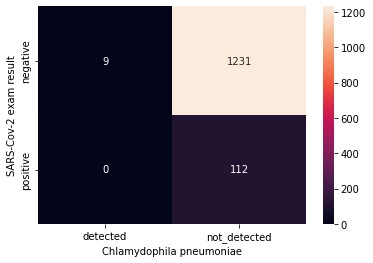

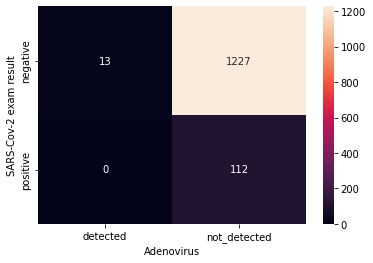

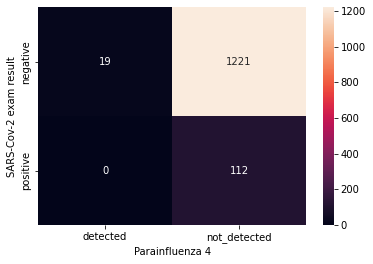

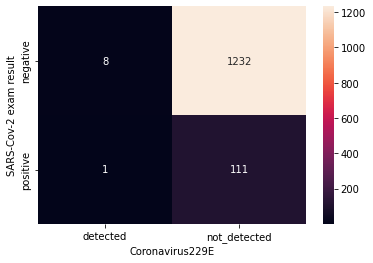

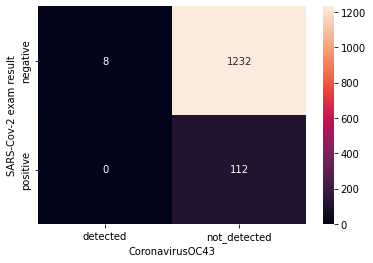

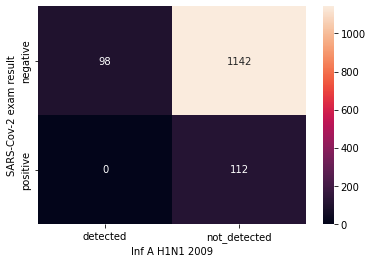

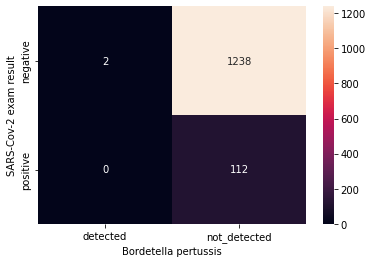

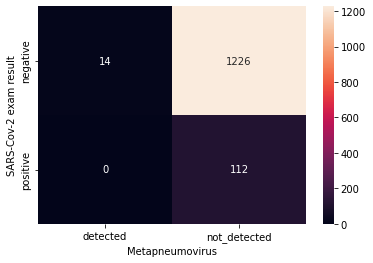

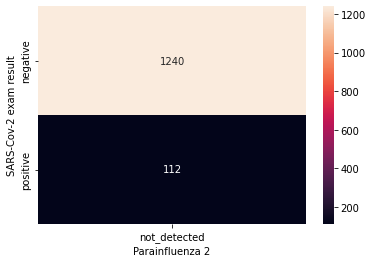

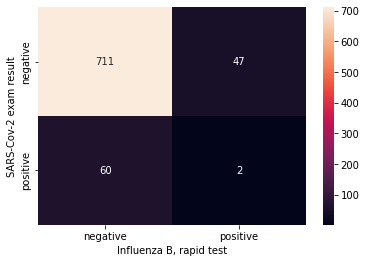

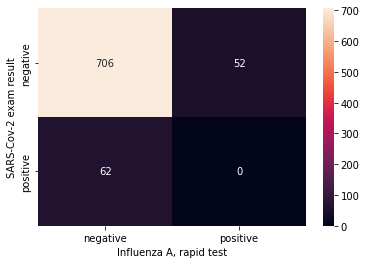

In [30]:
for col in viral_columns:
    plt.figure()
    sns.heatmap(pd.crosstab(df['SARS-Cov-2 exam result'], df[col]), annot=True, fmt='d')

## Analyse un peu plus Avancée
### Relation Variables / Variables
### relations Taux Sanguin

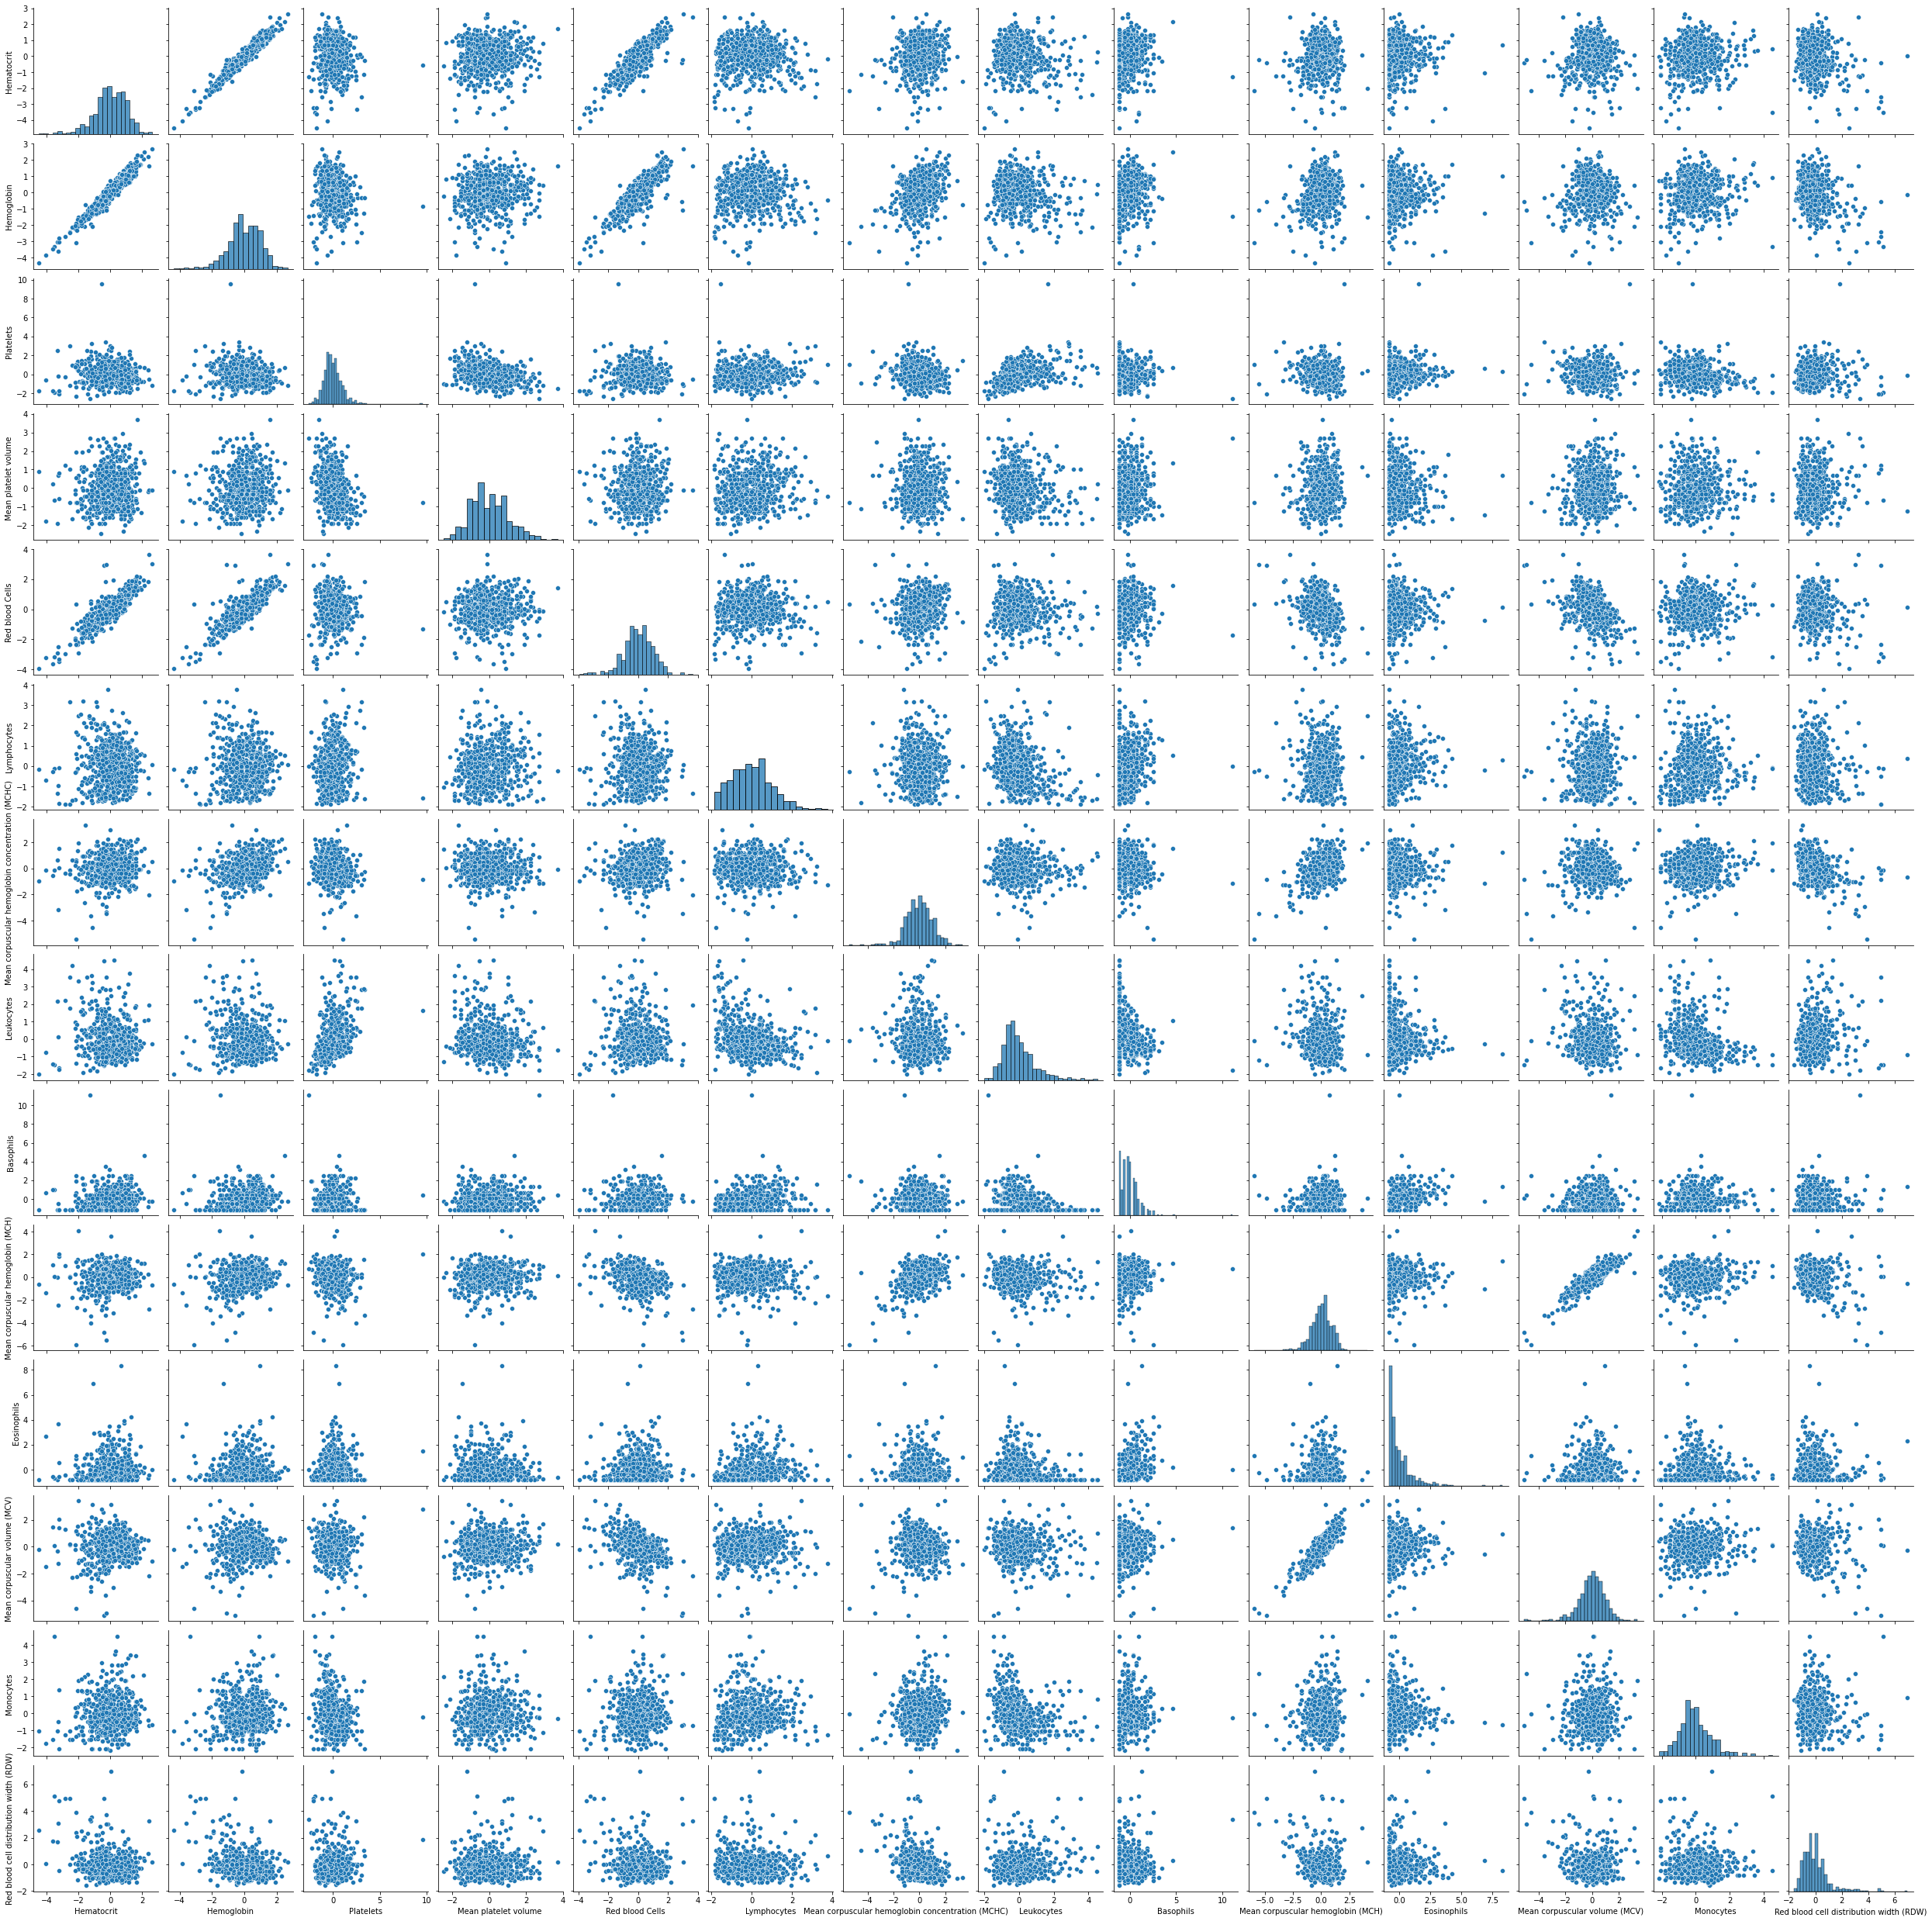

In [31]:
sns.pairplot(df[blood_columns])

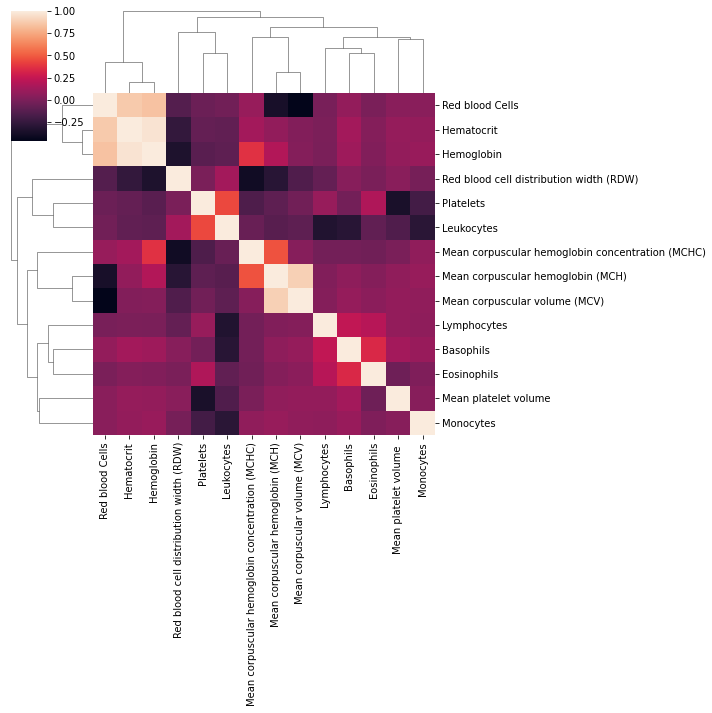

In [32]:
sns.clustermap(df[blood_columns].corr())

## Relation Age / Sang

/var/folders/xj/q_ykfdf11fx3n7wrhv2vzb5h0000gn/T/ipykernel_2580/695644951.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


<Figure size 432x288 with 0 Axes>

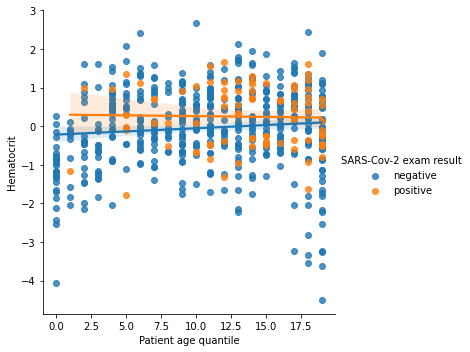

<Figure size 432x288 with 0 Axes>

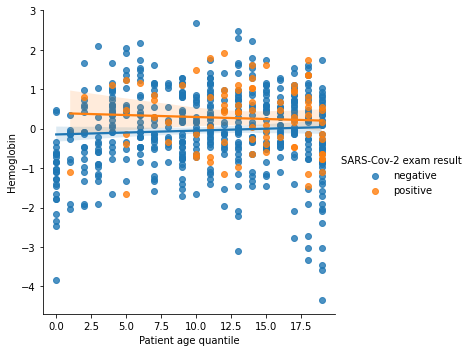

<Figure size 432x288 with 0 Axes>

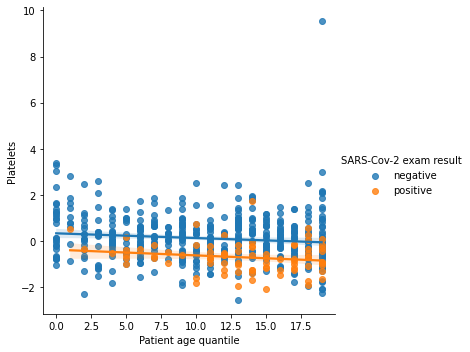

<Figure size 432x288 with 0 Axes>

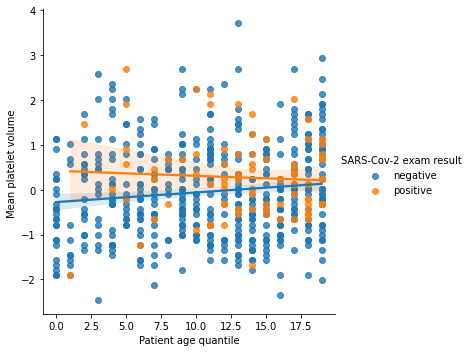

<Figure size 432x288 with 0 Axes>

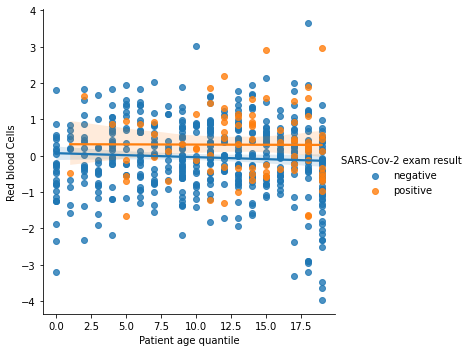

<Figure size 432x288 with 0 Axes>

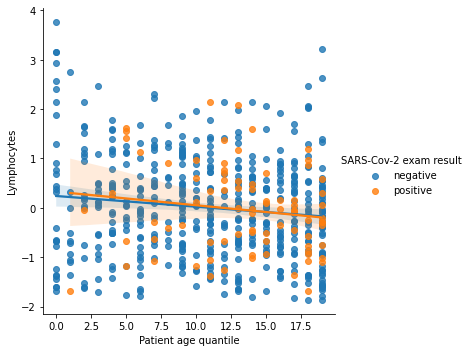

<Figure size 432x288 with 0 Axes>

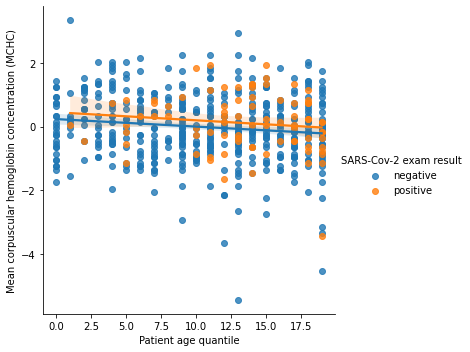

<Figure size 432x288 with 0 Axes>

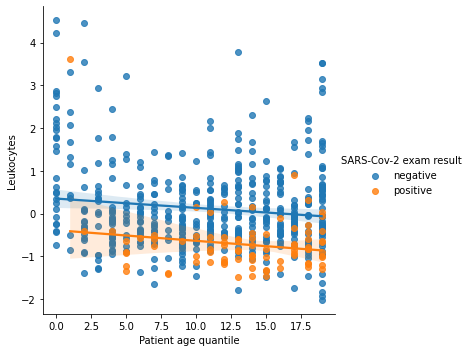

<Figure size 432x288 with 0 Axes>

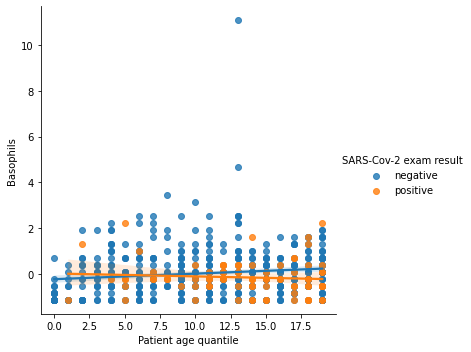

<Figure size 432x288 with 0 Axes>

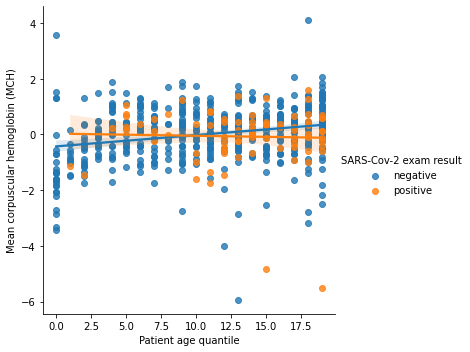

<Figure size 432x288 with 0 Axes>

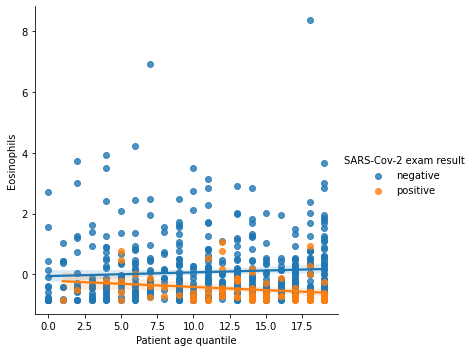

<Figure size 432x288 with 0 Axes>

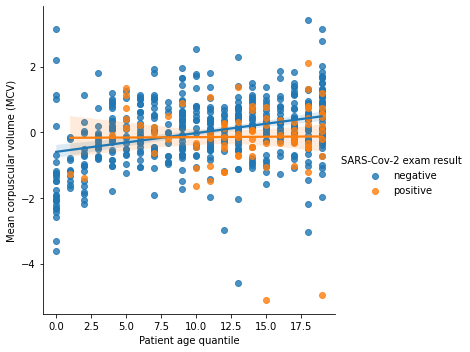

<Figure size 432x288 with 0 Axes>

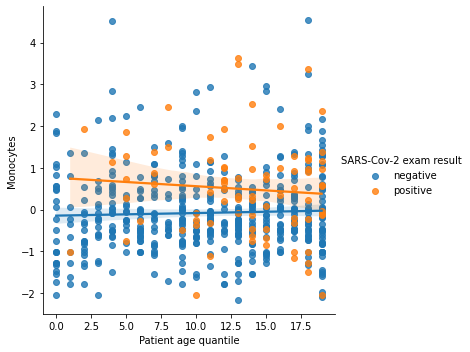

<Figure size 432x288 with 0 Axes>

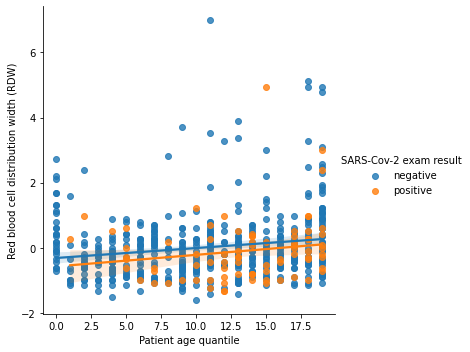

In [33]:
for col in blood_columns:
    plt.figure()
    sns.lmplot(x='Patient age quantile', y=col, hue='SARS-Cov-2 exam result', data=df)

In [34]:
df.corr()['Patient age quantile'].sort_values()

Leukocytes                                              -0.166386
Platelets                                               -0.158683
Lymphocytes                                             -0.125935
Mean corpuscular hemoglobin concentration (MCHC)        -0.124671
Red blood Cells                                         -0.037510
Patient addmited to intensive care unit (1=yes, 0=no)   -0.035772
Patient addmited to semi-intensive unit (1=yes, 0=no)    0.015736
Eosinophils                                              0.022085
Patient addmited to regular ward (1=yes, 0=no)           0.046166
Monocytes                                                0.050962
Hemoglobin                                               0.060320
Hematocrit                                               0.096808
Basophils                                                0.107525
Mean platelet volume                                     0.119449
Red blood cell distribution width (RDW)                  0.166429
Mean corpu

### Relation entre Influenza et rapid test

In [35]:
pd.crosstab(df['Influenza A'], df['Influenza A, rapid test'])

Influenza A, rapid test  negative  positive
Influenza A                                
detected                        2         4
not_detected                  245        15

In [36]:
pd.crosstab(df['Influenza B'], df['Influenza B, rapid test'])

Influenza B, rapid test  negative  positive
Influenza B                                
detected                       18        11
not_detected                  233         4

### relation Viral / sanguin 
#### Création d'une nouvelle variable "est malade"

In [37]:
df['est malade'] = np.sum(df[viral_columns[:-2]] == 'detected', axis=1) >=1

In [38]:
df.head()

Patient age quantile SARS-Cov-2 exam result  \
Patient ID                                                     
44477f75e8169d2                    13               negative   
126e9dd13932f68                    17               negative   
a46b4402a0e5696                     8               negative   
f7d619a94f97c45                     5               negative   
d9e41465789c2b5                    15               negative   

                 Patient addmited to regular ward (1=yes, 0=no)  \
Patient ID                                                        
44477f75e8169d2                                               0   
126e9dd13932f68                                               0   
a46b4402a0e5696                                               0   
f7d619a94f97c45                                               0   
d9e41465789c2b5                                               0   

                 Patient addmited to semi-intensive unit (1=yes, 0=no)  \
Patient ID                                                               
44477f75e8169d2                                                  0       
126e9dd13932f68                                                  0       
a46b4402a0e5696                                                  0       
f7d619a94f97c45                                                  0       
d9e41465789c2b5                                                  0       

                 Patient addmited to intensive care unit (1=yes, 0=no)  \
Patient ID                                                               
44477f75e8169d2                                                  0       
126e9dd13932f68                                                  0       
a46b4402a0e5696                                                  0       
f7d619a94f97c45                                                  0       
d9e41465789c2b5                                                  0       

                 Hematocrit  Hemoglobin  Platelets  Mean platelet volume   \
Patient ID                                                                  
44477f75e8169d2         NaN         NaN        NaN                    NaN   
126e9dd13932f68    0.236515    -0.02234  -0.517413               0.010677   
a46b4402a0e5696         NaN         NaN        NaN                    NaN   
f7d619a94f97c45         NaN         NaN        NaN                    NaN   
d9e41465789c2b5         NaN         NaN        NaN                    NaN   

                 Red blood Cells  Lymphocytes  \
Patient ID                                      
44477f75e8169d2              NaN          NaN   
126e9dd13932f68         0.102004     0.318366   
a46b4402a0e5696              NaN          NaN   
f7d619a94f97c45              NaN          NaN   
d9e41465789c2b5              NaN          NaN   

                 Mean corpuscular hemoglobin concentration (MCHC)  Leukocytes  \
Patient ID                                                                      
44477f75e8169d2                                               NaN         NaN   
126e9dd13932f68                                          -0.95079    -0.09461   
a46b4402a0e5696                                               NaN         NaN   
f7d619a94f97c45                                               NaN         NaN   
d9e41465789c2b5                                               NaN         NaN   

                 Basophils  Mean corpuscular hemoglobin (MCH)  Eosinophils  \
Patient ID                                                                   
44477f75e8169d2        NaN                                NaN          NaN   
126e9dd13932f68  -0.223767                          -0.292269     1.482158   
a46b4402a0e5696        NaN                                NaN          NaN   
f7d619a94f97c45        NaN                                NaN          NaN   
d9e41465789c2b5        NaN                                NaN          NaN   

                 Mean corpuscular volume (MCV)  Monocytes  \


In [39]:
malade_df = df[df['est malade'] == True]
non_malade_df = df[df['est malade'] == False]

/usr/local/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

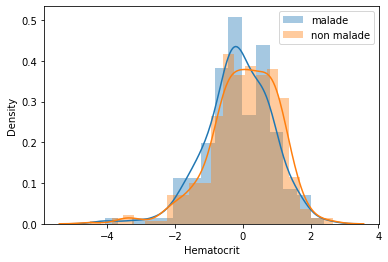

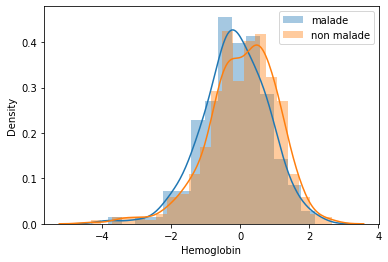

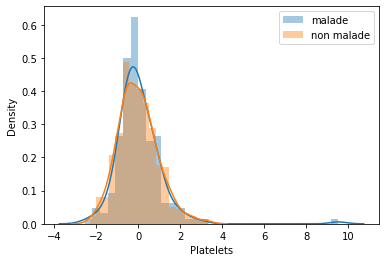

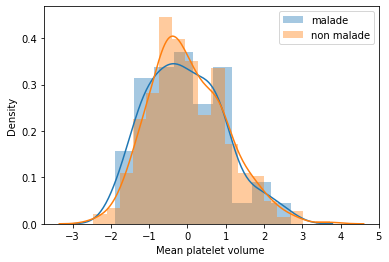

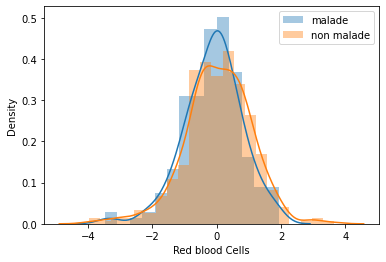

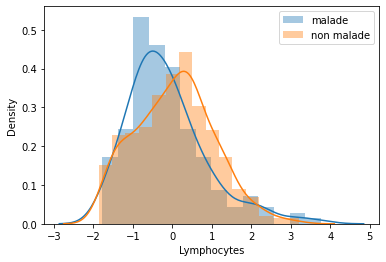

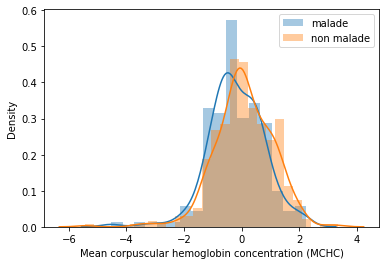

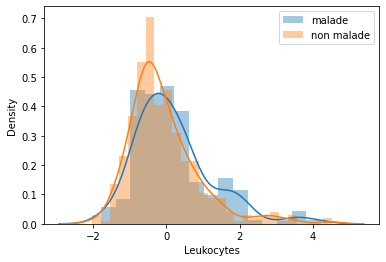

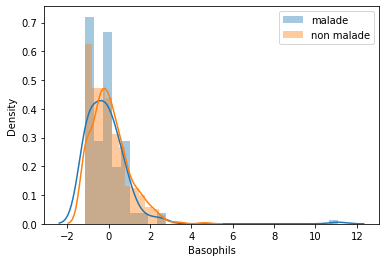

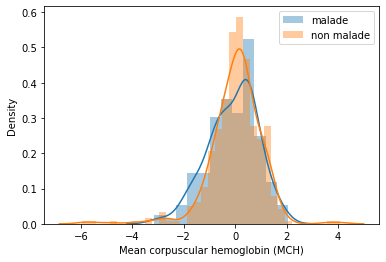

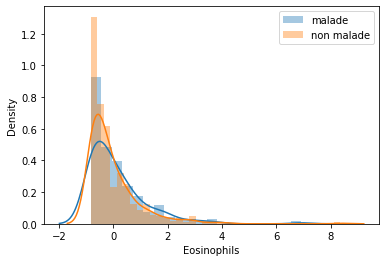

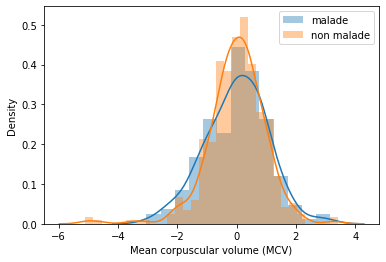

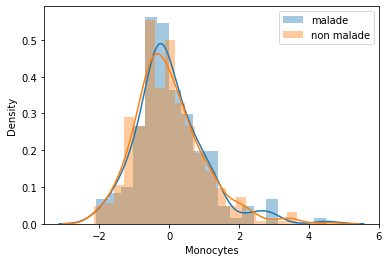

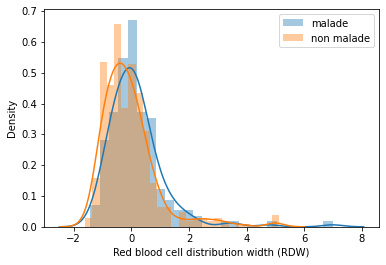

In [40]:
for col in blood_columns:
    plt.figure()
    sns.distplot(malade_df[col], label='malade')
    sns.distplot(non_malade_df[col], label='non malade')
    plt.legend()

In [41]:
def hospitalisation(df):
    if df['Patient addmited to regular ward (1=yes, 0=no)'] == 1:
        return 'surveillance'
    elif df['Patient addmited to semi-intensive unit (1=yes, 0=no)'] == 1:
        return 'soins semi-intensives'
    elif df['Patient addmited to intensive care unit (1=yes, 0=no)'] == 1:
        return 'soins intensifs'
    else:
        return 'inconnu'

In [42]:
df['statut'] = df.apply(hospitalisation, axis=1)

In [43]:
df.head()

Patient age quantile SARS-Cov-2 exam result  \
Patient ID                                                     
44477f75e8169d2                    13               negative   
126e9dd13932f68                    17               negative   
a46b4402a0e5696                     8               negative   
f7d619a94f97c45                     5               negative   
d9e41465789c2b5                    15               negative   

                 Patient addmited to regular ward (1=yes, 0=no)  \
Patient ID                                                        
44477f75e8169d2                                               0   
126e9dd13932f68                                               0   
a46b4402a0e5696                                               0   
f7d619a94f97c45                                               0   
d9e41465789c2b5                                               0   

                 Patient addmited to semi-intensive unit (1=yes, 0=no)  \
Patient ID                                                               
44477f75e8169d2                                                  0       
126e9dd13932f68                                                  0       
a46b4402a0e5696                                                  0       
f7d619a94f97c45                                                  0       
d9e41465789c2b5                                                  0       

                 Patient addmited to intensive care unit (1=yes, 0=no)  \
Patient ID                                                               
44477f75e8169d2                                                  0       
126e9dd13932f68                                                  0       
a46b4402a0e5696                                                  0       
f7d619a94f97c45                                                  0       
d9e41465789c2b5                                                  0       

                 Hematocrit  Hemoglobin  Platelets  Mean platelet volume   \
Patient ID                                                                  
44477f75e8169d2         NaN         NaN        NaN                    NaN   
126e9dd13932f68    0.236515    -0.02234  -0.517413               0.010677   
a46b4402a0e5696         NaN         NaN        NaN                    NaN   
f7d619a94f97c45         NaN         NaN        NaN                    NaN   
d9e41465789c2b5         NaN         NaN        NaN                    NaN   

                 Red blood Cells  Lymphocytes  \
Patient ID                                      
44477f75e8169d2              NaN          NaN   
126e9dd13932f68         0.102004     0.318366   
a46b4402a0e5696              NaN          NaN   
f7d619a94f97c45              NaN          NaN   
d9e41465789c2b5              NaN          NaN   

                 Mean corpuscular hemoglobin concentration (MCHC)  Leukocytes  \
Patient ID                                                                      
44477f75e8169d2                                               NaN         NaN   
126e9dd13932f68                                          -0.95079    -0.09461   
a46b4402a0e5696                                               NaN         NaN   
f7d619a94f97c45                                               NaN         NaN   
d9e41465789c2b5                                               NaN         NaN   

                 Basophils  Mean corpuscular hemoglobin (MCH)  Eosinophils  \
Patient ID                                                                   
44477f75e8169d2        NaN                                NaN          NaN   
126e9dd13932f68  -0.223767                          -0.292269     1.482158   
a46b4402a0e5696        NaN                                NaN          NaN   
f7d619a94f97c45        NaN                                NaN          NaN   
d9e41465789c2b5        NaN                                NaN          NaN   

                 Mean corpuscular volume (MCV)  Monocytes  \


/usr/local/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

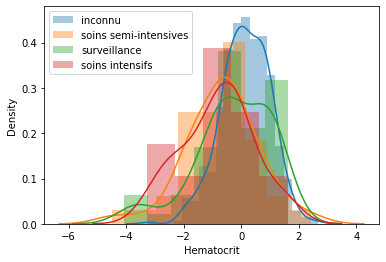

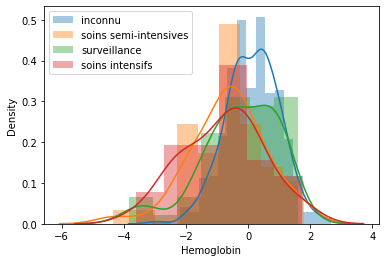

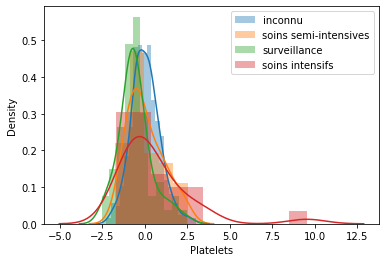

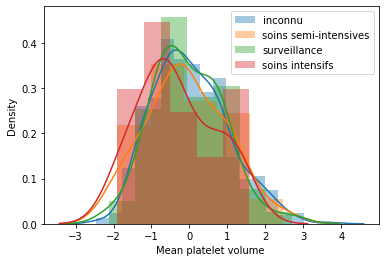

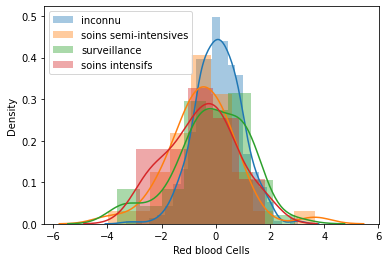

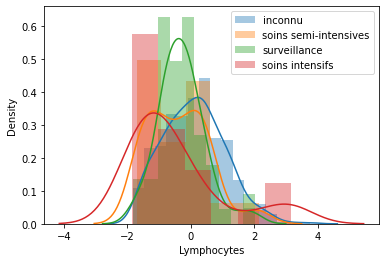

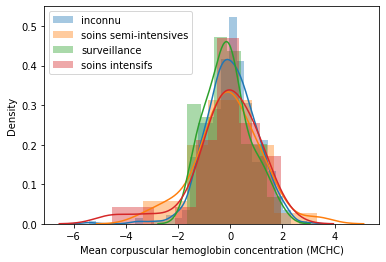

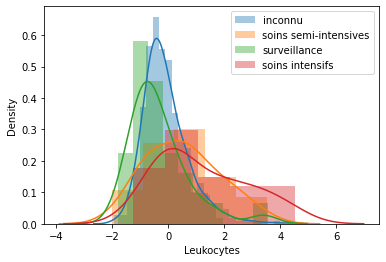

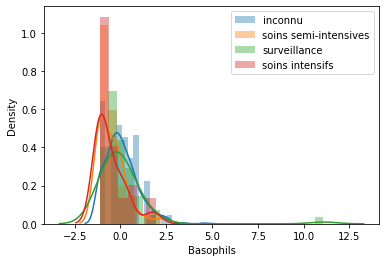

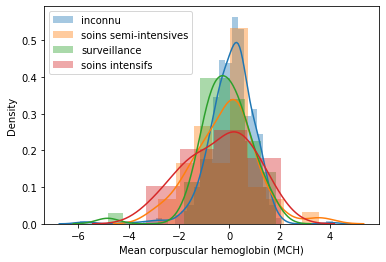

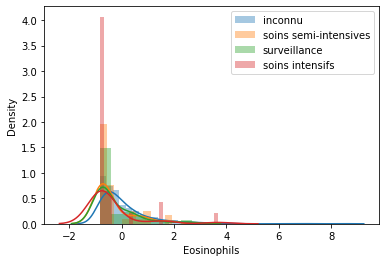

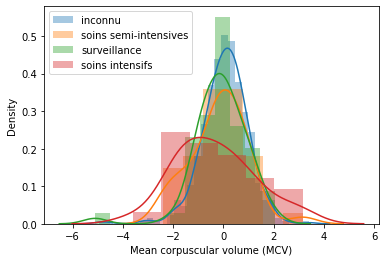

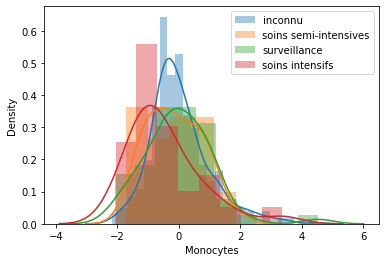

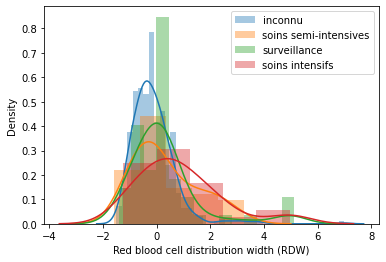

In [44]:
for col in blood_columns:
    plt.figure()
    for cat in df['statut'].unique():
        sns.distplot(df[df['statut']==cat][col], label=cat)
    plt.legend()

In [45]:
df[blood_columns].count()

Hematocrit                                          603
Hemoglobin                                          603
Platelets                                           602
Mean platelet volume                                599
Red blood Cells                                     602
Lymphocytes                                         602
Mean corpuscular hemoglobin concentration (MCHC)    602
Leukocytes                                          602
Basophils                                           602
Mean corpuscular hemoglobin (MCH)                   602
Eosinophils                                         602
Mean corpuscular volume (MCV)                       602
Monocytes                                           601
Red blood cell distribution width (RDW)             602
dtype: int64

In [46]:
df[viral_columns].count()

Respiratory Syncytial Virus    1354
Influenza A                    1354
Influenza B                    1354
Parainfluenza 1                1352
CoronavirusNL63                1352
Rhinovirus/Enterovirus         1352
Coronavirus HKU1               1352
Parainfluenza 3                1352
Chlamydophila pneumoniae       1352
Adenovirus                     1352
Parainfluenza 4                1352
Coronavirus229E                1352
CoronavirusOC43                1352
Inf A H1N1 2009                1352
Bordetella pertussis           1352
Metapneumovirus                1352
Parainfluenza 2                1352
Influenza B, rapid test         820
Influenza A, rapid test         820
dtype: int64

In [47]:
df1 = df[viral_columns[:-2]]
df1['covid'] = df['SARS-Cov-2 exam result']
df1.dropna()['covid'].value_counts(normalize=True)

/var/folders/xj/q_ykfdf11fx3n7wrhv2vzb5h0000gn/T/ipykernel_2580/3520532109.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['covid'] = df['SARS-Cov-2 exam result']


negative    0.91716
positive    0.08284
Name: covid, dtype: float64

In [48]:
df2 = df[blood_columns]
df2['covid'] = df['SARS-Cov-2 exam result']
df2.dropna()['covid'].value_counts(normalize=True)

/var/folders/xj/q_ykfdf11fx3n7wrhv2vzb5h0000gn/T/ipykernel_2580/4103850288.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['covid'] = df['SARS-Cov-2 exam result']


negative    0.864548
positive    0.135452
Name: covid, dtype: float64

## T-Test

In [49]:
from scipy.stats import ttest_ind

In [50]:
positive_df

Patient age quantile SARS-Cov-2 exam result  \
Patient ID                                                     
78511c183ae18bc                     7               positive   
d7834ed75f2da44                    16               positive   
b16b49f7bd3e692                    10               positive   
4382f5ea05e60c4                     2               positive   
d3729cd2658ca64                    15               positive   
...                               ...                    ...   
5c386388ba3c3f0                    16               positive   
9f8dfe2ae239238                     4               positive   
db77903261ab6d0                    15               positive   
ae66feb9e4dc3a0                     3               positive   
2697fdccbfeb7f7                    19               positive   

                 Patient addmited to regular ward (1=yes, 0=no)  \
Patient ID                                                        
78511c183ae18bc                                               0   
d7834ed75f2da44                                               1   
b16b49f7bd3e692                                               0   
4382f5ea05e60c4                                               0   
d3729cd2658ca64                                               0   
...                                                         ...   
5c386388ba3c3f0                                               0   
9f8dfe2ae239238                                               0   
db77903261ab6d0                                               0   
ae66feb9e4dc3a0                                               0   
2697fdccbfeb7f7                                               0   

                 Patient addmited to semi-intensive unit (1=yes, 0=no)  \
Patient ID                                                               
78511c183ae18bc                                                  0       
d7834ed75f2da44                                                  0       
b16b49f7bd3e692                                                  0       
4382f5ea05e60c4                                                  0       
d3729cd2658ca64                                                  0       
...                                                            ...       
5c386388ba3c3f0                                                  0       
9f8dfe2ae239238                                                  0       
db77903261ab6d0                                                  0       
ae66feb9e4dc3a0                                                  0       
2697fdccbfeb7f7                                                  0       

                 Patient addmited to intensive care unit (1=yes, 0=no)  \
Patient ID                                                               
78511c183ae18bc                                                  0       
d7834ed75f2da44                                                  0       
b16b49f7bd3e692                                                  0       
4382f5ea05e60c4                                                  0       
d3729cd2658ca64                                                  0       
...                                                            ...       
5c386388ba3c3f0                                                  0       
9f8dfe2ae239238                                                  0       
db77903261ab6d0                                                  0       
ae66feb9e4dc3a0                                                  0       
2697fdccbfeb7f7                                                  0       

                 Hematocrit  Hemoglobin  Platelets  Mean platelet volume   \
Patient ID                                                                  
78511c183ae18bc         NaN         NaN        NaN                    NaN   
d7834ed75f2da44         NaN         NaN        NaN                    NaN   
b16b49f7bd3e692         NaN         NaN        NaN                    NaN   
4

In [51]:
balanced_neg = negative_df.sample(positive_df.shape[0])

In [52]:
def t_test(col):
    alpha = 0.02
    stat, p = ttest_ind(balanced_neg[col].dropna(), positive_df[col].dropna())
    if p < alpha:
        return 'H0 Rejetée'
    else :
        return 0

In [53]:
for col in blood_columns:
    print(f'{col :-<50} {t_test(col)}')

Hematocrit---------------------------------------- 0
Hemoglobin---------------------------------------- 0
Platelets----------------------------------------- H0 Rejetée
Mean platelet volume ----------------------------- 0
Red blood Cells----------------------------------- 0
Lymphocytes--------------------------------------- 0
Mean corpuscular hemoglobin concentration (MCHC)-- 0
Leukocytes---------------------------------------- H0 Rejetée
Basophils----------------------------------------- 0
Mean corpuscular hemoglobin (MCH)----------------- 0
Eosinophils--------------------------------------- H0 Rejetée
Mean corpuscular volume (MCV)--------------------- 0
Monocytes----------------------------------------- H0 Rejetée
Red blood cell distribution width (RDW)----------- 0
